In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy.random as npr

import jax.numpy as jnp
import jax 

from scipy.optimize import curve_fit
from jax.experimental.ode import odeint
from jax.scipy.optimize import minimize

import pickle

In [2]:
def logistic(t, y0, r, K):
    return K / (1 - (1 - K/y0) * jnp.exp(-r * t))

def logistic_loss(params, t, y):
    yhat = logistic(t, *params)
    return jnp.mean((yhat - y)**2)

In [3]:
K = 1.2
r = 0.5
y0 = 0.2
reps = 5
t = jnp.linspace(0, 24, 24*2)
t = jnp.array([t]*reps).squeeze()

In [4]:
y = logistic(t, y0, r, K) 
y += npr.normal(0, y*0.025, size=t.shape)
y = y.squeeze()

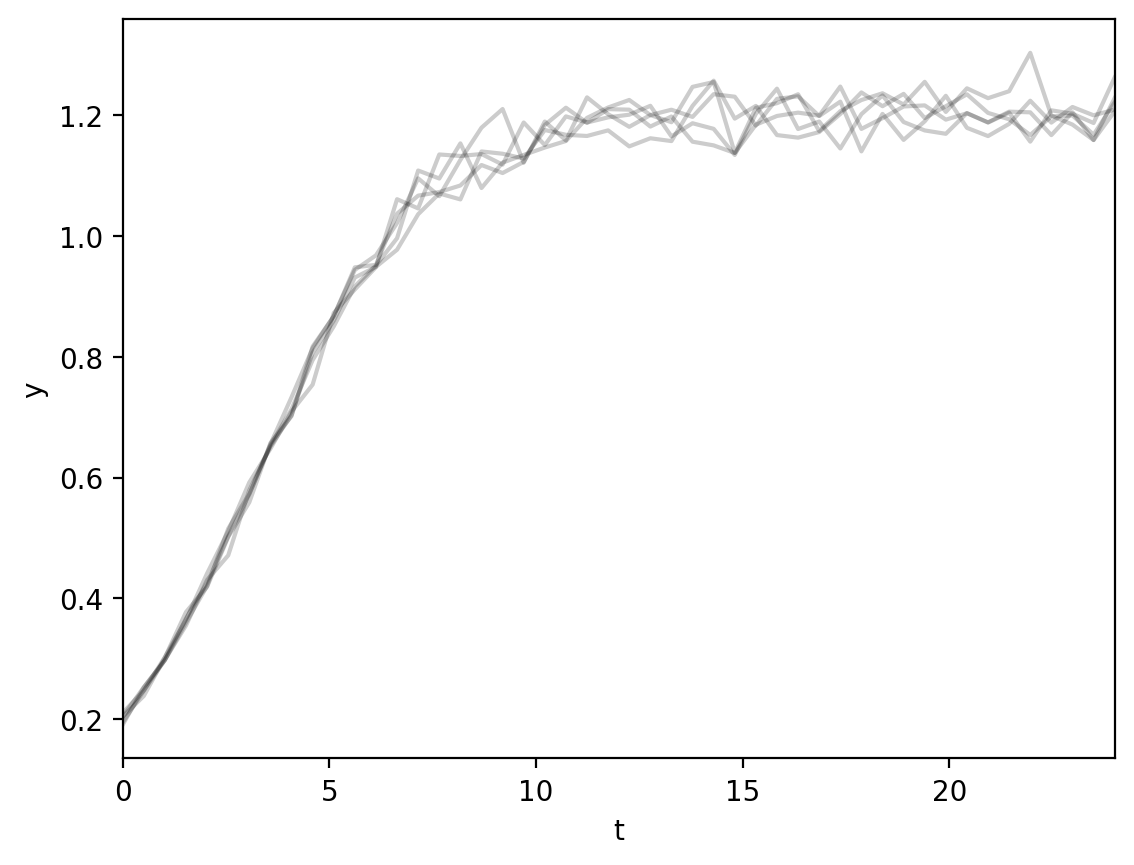

In [5]:
plt.plot(t.T, y.T, '-k', alpha=1/reps)
plt.xlabel('t')
plt.ylabel('y')
plt.xlim(0, 24);

### Curve fitting the equation

In [6]:
params_guess = jnp.array([y.min(), 1, y.max()])
%time params, pcov = curve_fit(logistic, t.ravel(), y.ravel(), params_guess)

CPU times: user 84.8 ms, sys: 2.8 ms, total: 87.6 ms
Wall time: 87.8 ms


0.2 0.5 1.2 | 0.0006755638
0.1999 0.4979 1.2032  | 0.00066955865


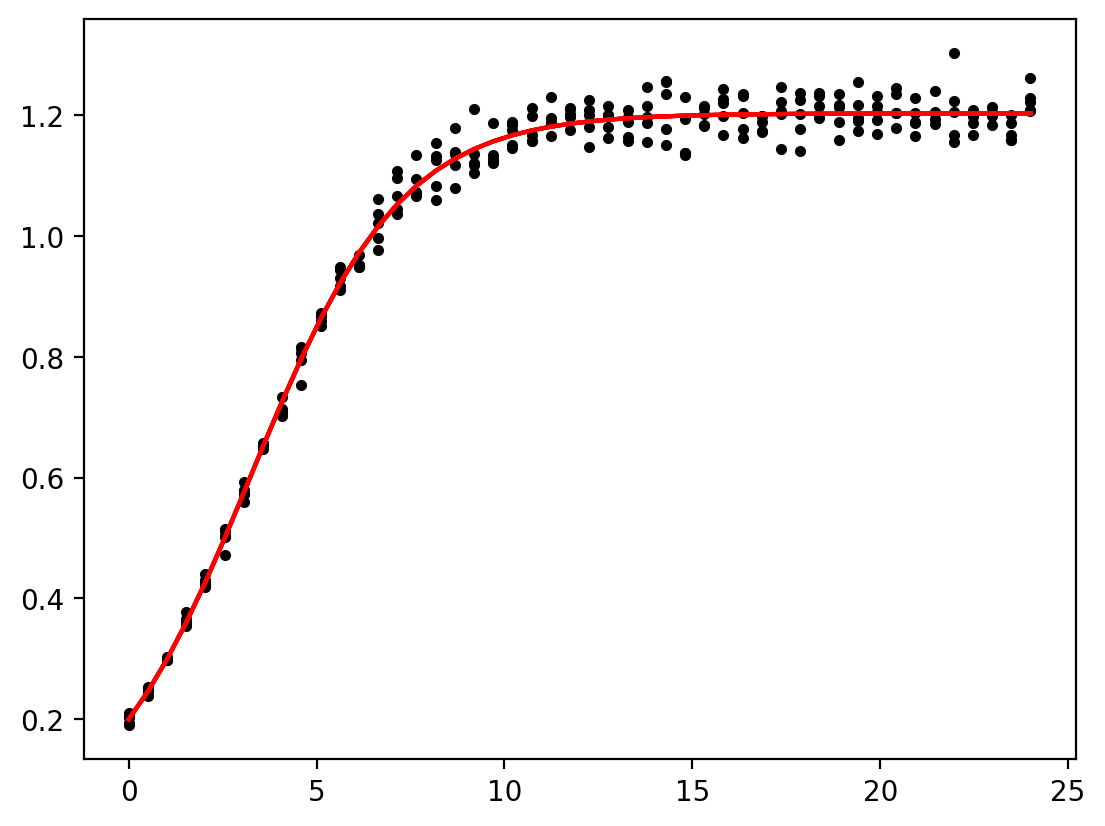

In [7]:
print(y0, r, K, '|', logistic_loss((y0, r, K), t, y))
print(("{:.4f} "*3).format(*params), '|', logistic_loss(params, t, y))

plt.plot(t, y, '.k')
plt.plot(t.T, logistic(t, *params).T, '-r');

### Curve fitting the logistic ODE - JAX

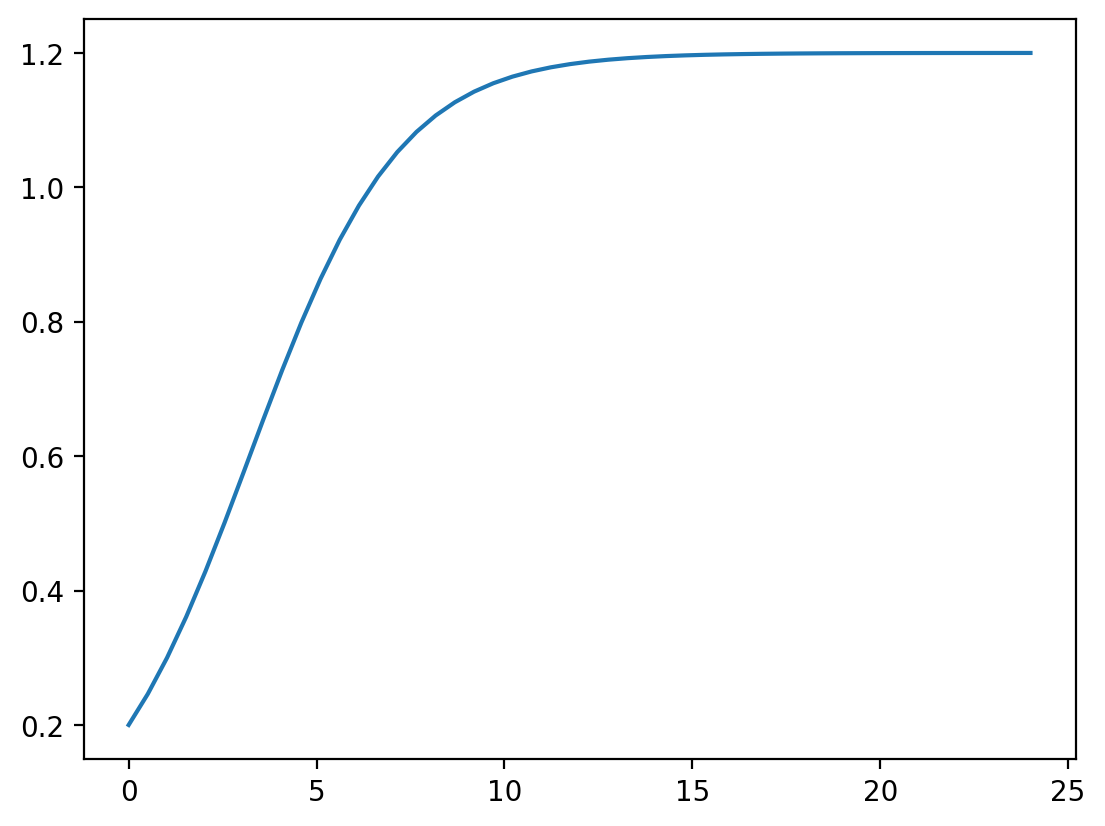

In [8]:
def logistic_ode(y, t, r, K):
    return r * y * (1 - y/K)

def logistic_odeint(t, y0, r, K):
    return odeint(logistic_ode, y0, t, r, K)

plt.plot(t[0], logistic_odeint(t[0], y0, r, K));

In [9]:
def logistic_odeint_loss(params, t, y):
    yhat = logistic_odeint(t, *params).reshape((1, -1))
    return jnp.mean((yhat - y)**2)

print(logistic_odeint_loss([y0, r, K], t[0], y))

0.0006755643


In [10]:
%time res_minimize = minimize(logistic_odeint_loss, params_guess, args=(t[0], y), method='BFGS')
print(res_minimize.success)

CPU times: user 4.09 s, sys: 153 ms, total: 4.25 s
Wall time: 4.17 s
False


In [12]:
if not res_minimize.success:
    %time res_minimize = minimize(logistic_odeint_loss, res_minimize.x, args=(t[0], y), method='BFGS')
    print(res_minimize.success)

CPU times: user 2.93 s, sys: 91.8 ms, total: 3.02 s
Wall time: 2.95 s
True


0.2 0.5 1.2 | 0.0006755643
0.1999 0.4979 1.2032  | 0.0006695563


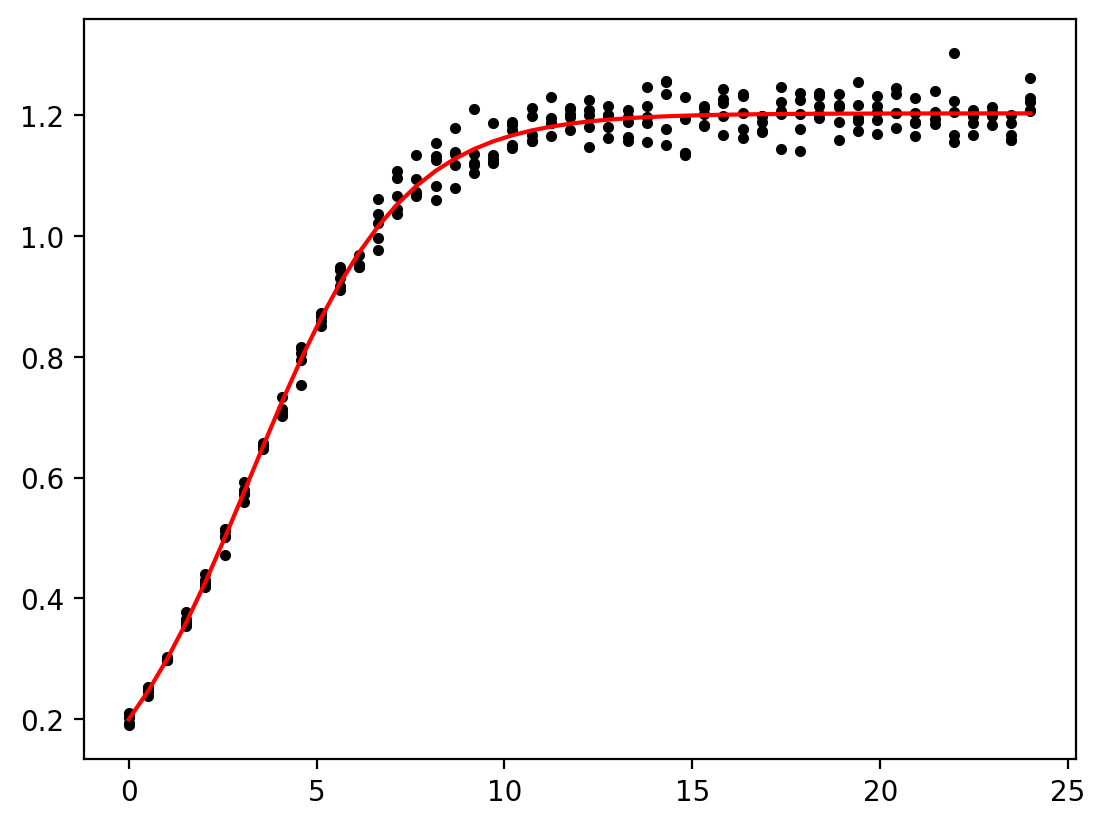

In [13]:
print(y0, r, K, '|', logistic_odeint_loss([y0, r, K], t[0], y))
print(("{:.4f} "*3).format(*res_minimize.x), '|', logistic_odeint_loss(res_minimize.x, t[0], y))

plt.plot(t, y, '.k')
plt.plot(t[0], logistic_odeint(t[0], *res_minimize.x), '-r');

# Better JAX

In [14]:
import diffrax, jaxopt, optax

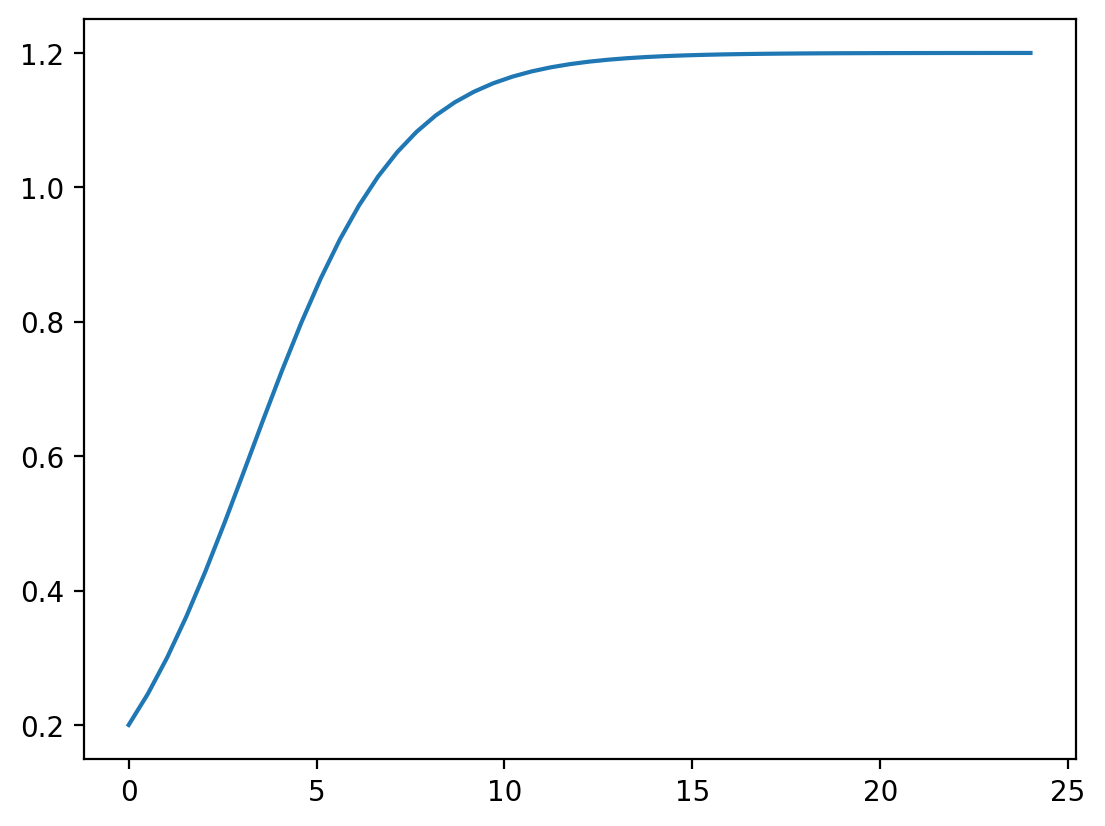

In [15]:
def logistic_ode(t, y, args):
    r, K = args
    return r * y * (1 - y/K)
term = diffrax.ODETerm(logistic_ode) 

def logistic_odeint(t, y0, r, K):
    solver = diffrax.Tsit5()
    sol = diffrax.diffeqsolve(
        term, solver, args=(r, K), saveat=diffrax.SaveAt(ts=t),
        t0=t[0], t1=t[-1], dt0=t[1]-t[0], y0=y0
    )
    return sol.ys

plt.plot(t[0], logistic_odeint(t[0], y0, r, K));

In [16]:
def logistic_odeint_loss(params, t, y):
    yhat = logistic_odeint(t, *params).reshape((1, -1))
    return jnp.mean((yhat - y)**2)

print(logistic_odeint_loss([y0, r, K], t[0], y))

0.0006755637


## JaxOpt

In [28]:
solver = jaxopt.GradientDescent(fun=logistic_odeint_loss)
%time res_jaxopt = solver.run(params_guess, t=t[0], y=y)

CPU times: user 3.78 s, sys: 131 ms, total: 3.91 s
Wall time: 3.83 s


0.2 0.5 1.2 | 0.0006755637
0.1907 0.5127 1.2008  | 0.0006840287


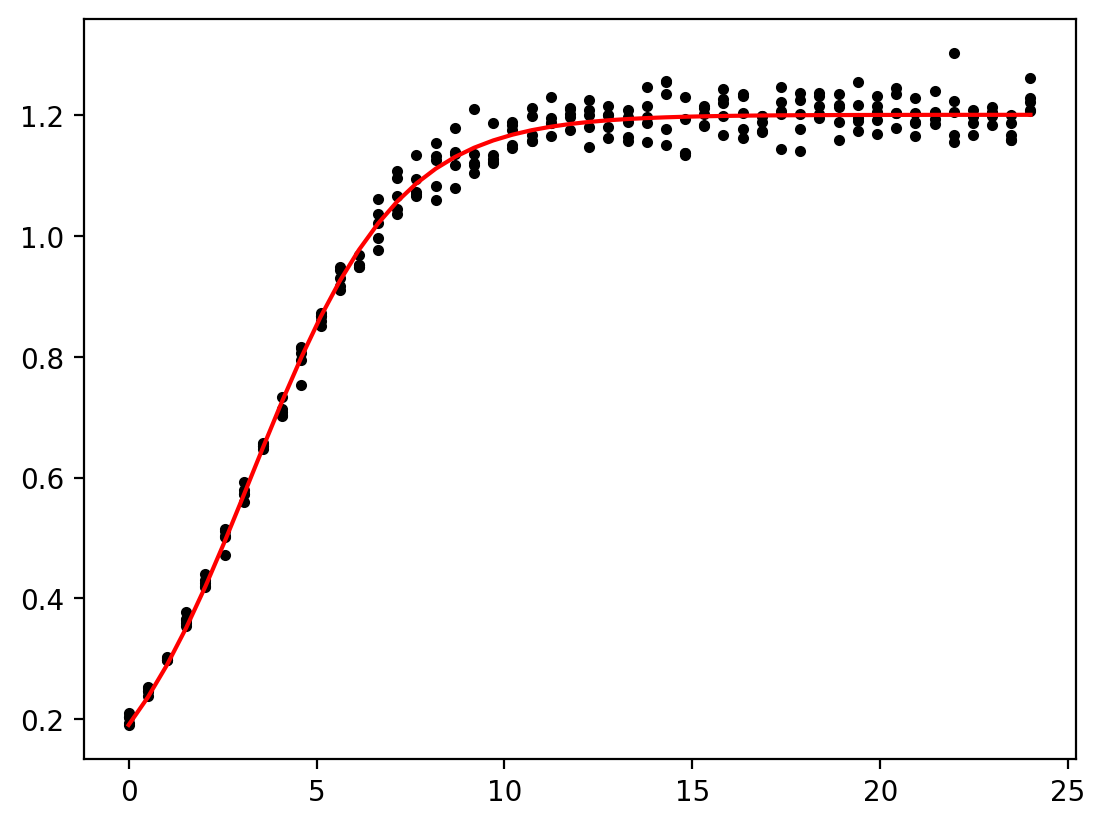

In [29]:
params_jaxopt, _ = res_jaxopt

print(y0, r, K, '|', logistic_odeint_loss([y0, r, K], t[0], y))
print(("{:.4f} "*3).format(*params_jaxopt), '|', logistic_odeint_loss(params_jaxopt, t[0], y))

plt.plot(t, y, '.k')
plt.plot(t[0], logistic_odeint(t[0], *params_jaxopt), '-r');

## Optax

In [30]:
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(params_guess)
loss_grad = jax.value_and_grad(logistic_odeint_loss)

@jax.jit
def step(params, opt_state):
    loss_value, grads = loss_grad(params, t[0], y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

step(params_guess, opt_state);

In [31]:
%%time
params_optax = params_guess
loss_prev = jnp.inf
i = 0
while True:
    i += 1
    params_optax, opt_state, loss_value = step(params_optax, opt_state)
    if i % 100 == 0:
        #print(f'step {i}, loss: {loss_value}, params: {params_optax}', flush=True)
        if abs(loss_value - loss_prev) < 1e-6:
            break
        else:
            loss_prev = loss_value

CPU times: user 83.1 ms, sys: 919 µs, total: 84 ms
Wall time: 82.9 ms


0.2 0.5 1.2 | 0.0006755637
0.1999 0.4979 1.2032  | 0.000669559


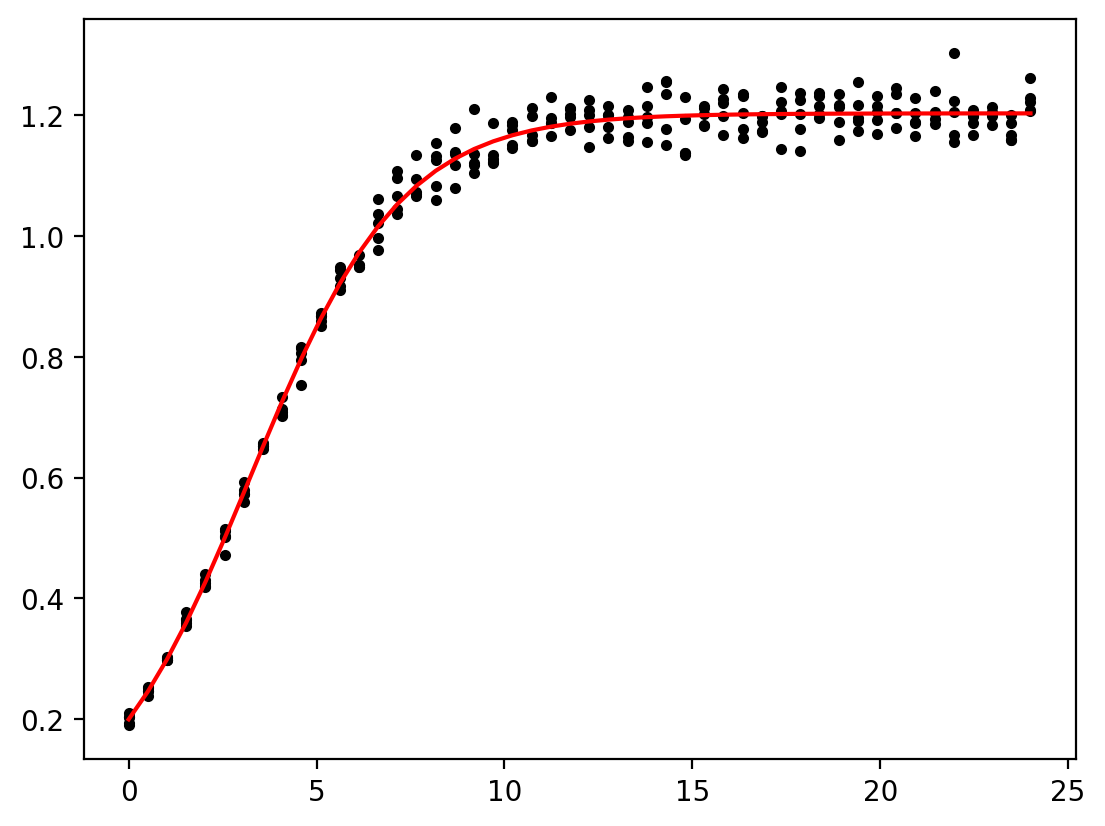

In [32]:
print(y0, r, K, '|', logistic_odeint_loss([y0, r, K], t[0], y))
print(("{:.4f} "*3).format(*params), '|', logistic_odeint_loss(params_optax, t[0], y))

plt.plot(t, y, '.k')
plt.plot(t[0], logistic_odeint(t[0], *params_optax), '-r');